
# Delta–Vega Hedging for One‑Month SPX Straddles (2000–2023)

This notebook implements the **delta–vega hedging** experiment described in the *Data‑driven hedging with generative models* (Cont & Vuletić, 2025) paper for a portfolio consisting of a one‑month **long straddle** with strike \(K = m_0 S_0\) where \(m_0 \in \{0.75, 0.8, 0.9, 1.1, 1.2, 1.25\}\. We follow their setup for **non‑overlapping one‑month windows** (≈21 trading days, \(\Delta t = 1/252\)), **ATM option as the volatility‑sensitive hedge**, and **self‑financing accounting** with transaction costs proxied by **half the bid‑ask spread**.

> Key hedge ratios (delta–vega hedging):
> - Portfolio vega: \(\kappa^V_t = \sum_{i\in P} \psi_i\,\kappa^{(i)}_t\) where the straddle is long 1 call and long 1 put (\(\psi_i=+1\)).  
> - Option hedge ratio: \(\varphi^{(1)}_t = \kappa^V_t / \kappa^H_t\) using an **ATM** one‑month option as \(H\).  
> - Underlying hedge ratio: \(\varphi^{(0)}_t = \Delta^V_t - \varphi^{(1)}_t\,\Delta^H_t\).


In [1]:

# === 1) Imports & configuration ===
import os
import math
import json
import warnings
from dataclasses import dataclass
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd

# yfinance for spot (will gracefully degrade if no internet)
try:
    import yfinance as yf
except Exception as e:
    yf = None
    warnings.warn(f'yfinance import failed ({e}). Spot fallback logic will be used.')

pd.set_option('display.max_columns', 200)

# Paths
OPTIONS_PARQUET = "../data/options_dataset.parquet"  # <-- adjust if needed

# Underlying ticker for SPX index on Yahoo
UNDERLYING_TICKER = "^GSPC"

# Experiment parameters
TRADING_DAYS_PER_MONTH = 21   # non-overlapping windows
DT = 1/252                    # day length
M0_SET = [0.75, 0.8, 0.9, 1.1, 1.2, 1.25]

# Hedging ATM moneyness target and maturity target (≈ one month)
HEDGE_TARGET_MONEYNESS = 1.0
TARGET_DTE = (TRADING_DAYS_PER_MONTH, TRADING_DAYS_PER_MONTH + 2)  # small tolerance

# Columns expected in the parquet
EXPECTED_COLS = [
    "optionid","ticker","date","exdate","cp_flag","strike_price","best_bid","best_offer",
    "volume","open_interest","impl_volatility","delta","gamma","vega","theta"
]


In [2]:

# === 2) Load option chain (OptionMetrics‑style) & basic cleaning ===
df = pd.read_parquet(OPTIONS_PARQUET)
missing = [c for c in EXPECTED_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Parquet is missing required columns: {missing}")

# Parse dates
df['date'] = pd.to_datetime(df['date'])
df['exdate'] = pd.to_datetime(df['exdate'])

# Compute mid prices and DTE (trading days proxy: business days distance)
df['mid'] = (df['best_bid'] + df['best_offer']) / 2.0
df['dte'] = (df['exdate'] - df['date']).dt.days

# Filter to SPX (rename if your ticker differs)
df = df[df['ticker'] == 'SPX'].copy()

# Remove obviously bad rows
df = df[df['dte'] >= 0]
df = df[~df['mid'].isna()]

print(df[['date','exdate','cp_flag','strike_price','mid','impl_volatility','delta','vega']].head())
print(f"Rows after cleaning: {len(df):,}")

# --- OPRA strike scaling auto-fix (apply once, before any moneyness calc) ---
# If strikes look like 1,505,000 instead of 1,505.00, divide by 1,000
if df['strike_price'].median() > 1e4:     # heuristic: clearly too large for SPX
    df['strike_price'] = df['strike_price'] / 1000.0

# Optional sanity checks
print(
    "Sanity check — strikes:",
    "min", round(df['strike_price'].min(), 2),
    "median", round(df['strike_price'].median(), 2),
    "max", round(df['strike_price'].max(), 2),
)



        date     exdate cp_flag  strike_price      mid  impl_volatility  \
0 2000-01-03 2000-01-22       P       1505000   56.250         0.212891   
1 2000-01-03 2000-01-22       P       1545000   90.625         0.233571   
2 2000-01-03 2000-03-18       C        750000  707.500              NaN   
3 2000-01-03 2000-09-16       C       1450000  136.750         0.229435   
4 2000-01-03 2000-06-17       P       1350000   41.750         0.252872   

      delta       vega  
0 -0.734362  105.97850  
1 -0.858130   72.57848  
2       NaN        NaN  
3  0.608151  461.04910  
4 -0.256190  313.84440  
Rows after cleaning: 36,251,366
Sanity check — strikes: min 50.0 median 2650.0 max 12000.0


In [3]:

# === 3) Spot loader (primary: yfinance; fallback: implied spot via moneyness if available) ===

def fetch_spot_history(start: pd.Timestamp, end: pd.Timestamp, ticker: str = UNDERLYING_TICKER) -> Optional[pd.Series]:
    """Fetch daily close spot from yfinance; returns a Series indexed by date (normalized to date)."""
    if yf is None:
        return None
    try:
        hist = yf.download(ticker, start=start - pd.Timedelta(days=5), end=end + pd.Timedelta(days=5), progress=False)
        if hist is None or hist.empty:
            return None
        s = hist['Adj Close'].copy()
        s.index = pd.to_datetime(s.index).tz_localize(None).normalize()
        s.name = 'spot'
        return s
    except Exception as e:
        warnings.warn(f"yfinance download failed: {e}")
        return None

def infer_spot_from_chain(day_df: pd.DataFrame) -> Optional[float]:
    """Fallback: estimate spot as strike closest to where call and put deltas are symmetric around ATM (crude)."""
    if day_df.empty:
        return None
    # Use minimum |delta_call + delta_put + 0| around ATM candidates
    piv = day_df.pivot_table(index='strike_price', columns='cp_flag', values='delta', aggfunc='mean')
    if {'C','P'}.issubset(piv.columns):
        score = (piv['C'] + piv['P']).abs()  # near zero when ATM (Delta_C ≈ 0.5, Delta_P ≈ -0.5)
        k_star = score.idxmin()
        return float(k_star)  # SPX options are in index points; ATM strike ~ spot
    # Otherwise, take mid of strikes weighted by vega as proxy
    grp = day_df.groupby('strike_price')['vega'].sum()
    if grp.empty:
        return None
    return float(grp.idxmax())

# Build a daily spot series spanning the options sample
start_date = df['date'].min().normalize()
end_date = df['date'].max().normalize()

spot_series = fetch_spot_history(start_date, end_date)
if spot_series is None:
    warnings.warn("Falling back to spot inference per day from option chain (coarse).")
    spot_series = (
        df.groupby('date', as_index=False)
          .apply(lambda g: pd.Series({'spot': infer_spot_from_chain(g.droplevel(0) if isinstance(g.index, pd.MultiIndex) else g)}))
          .set_index('date')['spot']
    )

spot_series = spot_series.sort_index().dropna()
spot_series.head(), spot_series.index.min(), spot_series.index.max()


/var/folders/nn/tnz4z0cd38bby_992b16sj8h0000gn/T/ipykernel_51804/2911395699.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist = yf.download(ticker, start=start - pd.Timedelta(days=5), end=end + pd.Timedelta(days=5), progress=False)
/var/folders/nn/tnz4z0cd38bby_992b16sj8h0000gn/T/ipykernel_51804/2911395699.py:16: UserWarning: yfinance download failed: 'Adj Close'
  warnings.warn(f"yfinance download failed: {e}")
/var/folders/nn/tnz4z0cd38bby_992b16sj8h0000gn/T/ipykernel_51804/2911395699.py:41: UserWarning: Falling back to spot inference per day from option chain (coarse).
  warnings.warn("Falling back to spot inference per day from option chain (coarse).")
/var/folders/nn/tnz4z0cd38bby_992b16sj8h0000gn/T/ipykernel_51804/2911395699.py:44: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `inclu

(date
 2000-01-03    1500.0
 2000-01-04    1410.0
 2000-01-05    1410.0
 2000-01-06    1425.0
 2000-01-07    1500.0
 Name: spot, dtype: float64,
 Timestamp('2000-01-03 00:00:00'),
 Timestamp('2023-08-31 00:00:00'))

In [4]:

# === 4) Join spot, compute moneyness m = K / S_t, select near-1M instruments ===
df = df.merge(spot_series.rename('spot'), left_on='date', right_index=True, how='inner')
df['moneyness'] = df['strike_price'] / df['spot']

# Keep ≈ 1-month options (tolerance window)
df_1m = df[(df['dte'] >= TARGET_DTE[0]) & (df['dte'] <= TARGET_DTE[1])].copy()

print(df_1m[['date','cp_flag','strike_price','spot','moneyness','dte','mid','delta','vega']].head())
print(f"1M rows: {len(df_1m):,}")

# 1) moneyness sanity: should mostly be in a reasonable band around ATM
print(df_1m['moneyness'].describe())

# 2) alignment of spot and “ATM” strike at d0:
sample_day = df_1m['date'].min()
d0 = df_1m[df_1m['date'] == sample_day]
print("Sample d0 spot:", float(d0['spot'].iloc[0]))
print("Closest ATM strike:", d0.loc[(d0['strike_price'] - d0['spot']).abs().idxmin(), 'strike_price'])

# Clean & quality screens to prevent NaNs during hedging
df_1m = df_1m.replace([np.inf, -np.inf], np.nan)

# Require valid quotes and greeks
df_1m = df_1m.dropna(subset=['mid','delta','vega','best_bid','best_offer'])

# Guard against inverted quotes; compute spreads
df_1m = df_1m[df_1m['best_offer'] >= df_1m['best_bid']].copy()
df_1m['spread'] = (df_1m['best_offer'] - df_1m['best_bid']).clip(lower=0)
df_1m['rel_spread'] = (df_1m['spread'] / df_1m['mid']).replace([np.inf,-np.inf], np.nan)

# Basic liquidity: tighten to avoid dusty quotes (tune thresholds as needed)
liq_mask = (
    (df_1m['mid'] > 0.05) &
    (df_1m['rel_spread'] <= 0.35) &          # avoid super-wide quotes
    df_1m['delta'].between(-1.1, 1.1) &
    (df_1m['vega'] > 0)                      # exclude zero/negative vega rows (bad data)
)
df_1m = df_1m[liq_mask].copy()

print("After quality screens:", len(df_1m))




           date cp_flag  strike_price    spot  moneyness  dte     mid  \
9002 2000-01-27       C        1475.0  1415.0   1.042403   23   3.750   
9005 2000-01-27       P        1350.0  1415.0   0.954064   23  12.250   
9008 2000-01-27       C        1575.0  1415.0   1.113074   23   0.250   
9019 2000-01-27       C        1465.0  1415.0   1.035336   23   5.625   
9022 2000-01-27       C        1400.0  1415.0   0.989399   23  30.750   

         delta       vega  
9002  0.127699   71.74142  
9005 -0.244565  107.83600  
9008  0.010723    9.72553  
9019  0.172484   87.69729  
9022  0.529561  136.60340  
1M rows: 1,377,412
count    1.377412e+06
mean     9.146768e-01
std      1.882587e-01
min      2.125399e-02
25%      8.351254e-01
50%      9.443231e-01
75%      1.020408e+00
max      2.666667e+00
Name: moneyness, dtype: float64
Sample d0 spot: 1415.0
Closest ATM strike: 1420.0
After quality screens: 1044345


In [5]:
VEGA_FLOOR = 5.0

def choose_strike_for_m0(spot0: float, m0: float, available_strikes: np.ndarray) -> float:
    """Pick strike closest to m0 * spot0."""
    target = float(m0) * float(spot0)
    idx = np.abs(available_strikes - target).argmin()
    K = float(available_strikes[idx])
    print(f"[choose_strike_for_m0] spot0={spot0:.4f}, m0={m0:.3f}, target={target:.4f} -> K={K}")
    return K

def nearest_atm_strike(spot0: float, available_strikes: np.ndarray) -> float:
    """Pick strike closest to spot0."""
    idx = np.abs(available_strikes - float(spot0)).argmin()
    K = float(available_strikes[idx])
    print(f"[nearest_atm_strike] spot0={spot0:.4f} -> K_ATM={K}")
    return K

In [6]:
# Pick a concrete date (you can change this)
debug_date = df_1m['date'].min()
day_df = df_1m[df_1m['date'] == debug_date].copy()

print(f"[debug day] date={debug_date.date()}, rows={len(day_df)}")
print(day_df[['date','cp_flag','strike_price','spot','moneyness','dte','mid','delta','vega']].head())

# Extract spot and available strikes for this day
if day_df.empty:
    raise RuntimeError("No rows found for debug_date. Change `debug_date` to a date that exists.")
spot0 = float(day_df['spot'].iloc[0])
strikes_today = np.sort(day_df['strike_price'].unique())
print(f"[debug day] spot0={spot0}, strikes count={len(strikes_today)}, min={strikes_today.min()}, max={strikes_today.max()}")


[debug day] date=2000-01-27, rows=56
           date cp_flag  strike_price    spot  moneyness  dte     mid  \
9002 2000-01-27       C        1475.0  1415.0   1.042403   23   3.750   
9005 2000-01-27       P        1350.0  1415.0   0.954064   23  12.250   
9019 2000-01-27       C        1465.0  1415.0   1.035336   23   5.625   
9022 2000-01-27       C        1400.0  1415.0   0.989399   23  30.750   
9025 2000-01-27       C        1425.0  1415.0   1.007067   23  17.875   

         delta       vega  
9002  0.127699   71.74142  
9005 -0.244565  107.83600  
9019  0.172484   87.69729  
9022  0.529561  136.60340  
9025  0.386221  131.37020  
[debug day] spot0=1415.0, strikes count=31, min=1100.0, max=1520.0


In [7]:
# Choose m0 and view chosen strikes
m0 = 0.90  # <- change to test other values
K_straddle = choose_strike_for_m0(spot0, m0, strikes_today)
K_hedge = nearest_atm_strike(spot0, strikes_today)

# Show how many rows exist exactly at those strikes
c_straddle_rows = day_df[(day_df['strike_price'] == K_straddle) & (day_df['cp_flag'] == 'C')]
p_straddle_rows = day_df[(day_df['strike_price'] == K_straddle) & (day_df['cp_flag'] == 'P')]
hedge_call_rows = day_df[(day_df['strike_price'] == K_hedge) & (day_df['cp_flag'] == 'C')]
hedge_put_rows  = day_df[(day_df['strike_price'] == K_hedge) & (day_df['cp_flag'] == 'P')]

print(f"[counts] straddle K={K_straddle}: C={len(c_straddle_rows)}, P={len(p_straddle_rows)}")
print(f"[counts] hedge K_ATM={K_hedge}: C={len(hedge_call_rows)}, P={len(hedge_put_rows)}")


[choose_strike_for_m0] spot0=1415.0000, m0=0.900, target=1273.5000 -> K=1275.0
[nearest_atm_strike] spot0=1415.0000 -> K_ATM=1410.0
[counts] straddle K=1275.0: C=1, P=1
[counts] hedge K_ATM=1410.0: C=1, P=1


In [8]:
# Helper: pick ONE row for (strike, cp_flag) with explicit sorting preference
def pick_one(day_df: pd.DataFrame, strike: float, cp_flag: str) -> pd.Series | None:
    sub = day_df[(day_df['strike_price'] == strike) & (day_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        print(f"[pick_one] MISSING leg for cp={cp_flag}, K={strike}")
        return None
    # drop rows with bad/NaN greeks or quotes
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','vega','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        print(f"[pick_one] All candidates invalid for cp={cp_flag}, K={strike}")
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])  # avoid NaN rel spread rows

    # tighten selection
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        print(f"[pick_one] No clean candidate after filters for cp={cp_flag}, K={strike}")
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    print(f"[pick_one] cp={cp_flag}, K={strike}, dte={int(chosen['dte'])}, "
          f"mid={chosen['mid']:.4f}, delta={chosen['delta']:.4f}, vega={chosen['vega']:.4f}, "
          f"spread={chosen['spread']:.4f}, OI={int(chosen['open_interest'])}, vol={int(chosen['volume'])}")
    return chosen

# Pick straddle legs
row_C = pick_one(day_df, K_straddle, 'C')
row_P = pick_one(day_df, K_straddle, 'P')

# Pick hedge leg: prefer ATM Call; if missing, try ATM Put
row_H = pick_one(day_df, K_hedge, 'C')
if row_H is None:
    row_H = pick_one(day_df, K_hedge, 'P')

if (row_C is None) or (row_P is None) or (row_H is None):
    raise RuntimeError("One or more legs are missing. Check printed diagnostics above.")


[pick_one] cp=C, K=1275.0, dte=23, mid=133.2500, delta=0.9010, vega=59.8041, spread=2.0000, OI=28, vol=20
[pick_one] cp=P, K=1275.0, dte=23, mid=3.7500, delta=-0.0813, vega=51.6505, spread=0.7500, OI=10439, vol=1628
[pick_one] cp=C, K=1410.0, dte=23, mid=25.1250, delta=0.4737, vega=136.6808, spread=2.0000, OI=21, vol=11


In [9]:
def half_spread(row: pd.Series) -> float:
    hs = float(max(0.0, (row['best_offer'] - row['best_bid']) / 2.0))
    print(f"[half_spread] {row['cp_flag']} K={row['strike_price']} -> half-spread={hs:.4f}")
    return hs

def pnl_from_price_change(qty: float, price_t: float, price_t1: float) -> float:
    pnl = float(qty) * (float(price_t1) - float(price_t))
    print(f"[pnl] qty={qty}, from {price_t:.4f} to {price_t1:.4f} -> pnl={pnl:.6f}")
    return pnl

def self_financing_rebalance_cost(prev_qty: float, new_qty: float, half_spread_val: float) -> float:
    cost = abs(float(new_qty - prev_qty)) * float(half_spread_val)
    print(f"[rebalance_cost] prev={prev_qty:.6f}, new={new_qty:.6f}, half_spread={half_spread_val:.6f} -> cost={cost:.6f}")
    return cost


In [10]:
# Portfolio greeks (long 1C + 1P)
psi_C = 1.0
psi_P = 1.0
Delta_V = psi_C * row_C['delta'] + psi_P * row_P['delta']
Vega_V  = psi_C * row_C['vega']  + psi_P * row_P['vega']

# Hedge greeks
Delta_H = row_H['delta']
Vega_H  = row_H['vega']

# Apply vega floor for stability (optional)
Vega_H_eff = np.sign(Vega_H) * max(abs(Vega_H), VEGA_FLOOR)

phi_opt = Vega_V / Vega_H_eff if not np.isclose(Vega_H_eff, 0.0) else 0.0
phi_under = Delta_V - phi_opt * Delta_H

print(f"[hedge ratios] ΔV={Delta_V:.6f}, κV={Vega_V:.6f} | ΔH={Delta_H:.6f}, κH={Vega_H:.6f} "
      f"-> φ1 (opt)={phi_opt:.6f}, φ0 (under)={phi_under:.6f}")


[hedge ratios] ΔV=0.819772, κV=111.454610 | ΔH=0.473654, κH=136.680800 -> φ1 (opt)=0.815437, φ0 (under)=0.433537


In [11]:
# Find the next business date present in df_1m
dates_all = np.sort(df_1m['date'].unique())
try:
    idx = np.where(dates_all == debug_date)[0][0]
    next_date = pd.Timestamp(dates_all[idx+1])
except Exception:
    raise RuntimeError("No next date available after debug_date. Pick a different debug_date.")

print(f"[next day] current={debug_date.date()} -> next={next_date.date()}")

next_df = df_1m[df_1m['date'] == next_date].copy()
if next_df.empty:
    raise RuntimeError("No rows for next_date; cannot compute next-day P&L.")

# Try to fetch the SAME instruments on next day (same strikes + same cp_flags)
def fetch_next_row(next_df, strike, cp_flag):
    sub = next_df[(next_df['strike_price'] == strike) & (next_df['cp_flag'] == cp_flag)].copy()
    if sub.empty:
        print(f"[next fetch] MISSING next-day row for cp={cp_flag}, K={strike}")
        return None
    sub = sub.replace([np.inf, -np.inf], np.nan).dropna(subset=['mid','delta','vega','best_bid','best_offer'])
    sub = sub[sub['best_offer'] >= sub['best_bid']].copy()
    if sub.empty:
        print(f"[next fetch] All next-day candidates invalid for cp={cp_flag}, K={strike}")
        return None

    sub['spread'] = (sub['best_offer'] - sub['best_bid']).clip(lower=0)
    sub['rel_spread'] = (sub['spread'] / sub['mid']).replace([np.inf,-np.inf], np.nan)
    sub['dte_dist'] = (sub['dte'] - 21).abs()
    sub = sub.dropna(subset=['rel_spread'])
    sub = sub[(sub['rel_spread'] <= 0.35) & (sub['mid'] > 0.05)]
    if sub.empty:
        print(f"[next fetch] No clean next-day candidate for cp={cp_flag}, K={strike}")
        return None

    sub = sub.sort_values(by=['dte_dist','open_interest','volume','rel_spread'],
                          ascending=[True, False, False, True])
    chosen = sub.iloc[0]
    print(f"[next fetch] cp={cp_flag}, K={strike}, dte={int(chosen['dte'])}, mid={chosen['mid']:.4f}")
    return chosen

row_C_next = fetch_next_row(next_df, row_C['strike_price'], 'C') if row_C is not None else None
row_P_next = fetch_next_row(next_df, row_P['strike_price'], 'P') if row_P is not None else None
row_H_next = fetch_next_row(next_df, row_H['strike_price'], row_H['cp_flag']) if row_H is not None else None

if (row_C_next is None) or (row_P_next is None) or (row_H_next is None):
    raise RuntimeError("One or more next-day rows are missing — now you know exactly which one.")


[next day] current=2000-01-27 -> next=2000-01-28
[next fetch] cp=C, K=1275.0, dte=22, mid=94.6250
[next fetch] cp=P, K=1275.0, dte=22, mid=8.5000
[next fetch] cp=C, K=1410.0, dte=22, mid=11.1875


In [12]:
# Half-spread cost on the hedge option (at today's quote)
hs_H = half_spread(row_H)

# Option hedge P&L (hedge option only)
pnl_opt = pnl_from_price_change(phi_opt, row_H['mid'], row_H_next['mid'])

# Underlying P&L (using spot as mid; you can add costs if you like)
s_t  = float(row_C['spot'])   # equals row_P['spot'] == row_H['spot']
s_t1 = float(row_C_next['spot'])
pnl_under = pnl_from_price_change(phi_under, s_t, s_t1)

# Rebalance cost on the option (assume coming from 0 -> phi_opt today)
cost_opt = self_financing_rebalance_cost(0.0, phi_opt, hs_H)

print(f"[mini-step] pnl_opt={pnl_opt:.6f}, pnl_under={pnl_under:.6f}, cost_opt={cost_opt:.6f}, "
      f"daily_total={pnl_opt + pnl_under - cost_opt:.6f}")


[half_spread] C K=1410.0 -> half-spread=1.0000
[pnl] qty=0.8154372084447852, from 25.1250 to 11.1875 -> pnl=-11.365156
[pnl] qty=0.43353690447129367, from 1415.0000 to 1400.0000 -> pnl=-6.503054
[rebalance_cost] prev=0.000000, new=0.815437, half_spread=1.000000 -> cost=0.815437
[mini-step] pnl_opt=-11.365156, pnl_under=-6.503054, cost_opt=0.815437, daily_total=-18.683647


In [13]:
# === 6A) Build a single non-overlapping 1M window (≈21 trading days) ===
TRADING_DAYS_PER_MONTH = 21  # must match earlier

def get_window_dates(df_all: pd.DataFrame, start_idx: int) -> list[pd.Timestamp] | None:
    dates = np.sort(df_all['date'].unique())
    if start_idx + TRADING_DAYS_PER_MONTH >= len(dates):
        print(f"[get_window_dates] Not enough dates from start_idx={start_idx}.")
        return None
    # include end day (t+21) for next-day P&L on the last trading day
    days = list(dates[start_idx : start_idx + TRADING_DAYS_PER_MONTH + 1])
    print(f"[get_window_dates] start={pd.Timestamp(days[0]).date()} end={pd.Timestamp(days[-1]).date()} "
          f"len={len(days)} (includes final valuation day).")
    return days


In [ ]:
# === 6B) One step (day t -> t+1) with verbose checks ===
# Requires: pick_one(), half_spread(), pnl_from_price_change(), self_financing_rebalance_cost()
#           choose_strike_for_m0(), nearest_atm_strike(), VEGA_FLOOR

def one_day_step(df_all: pd.DataFrame,
                 d: pd.Timestamp,
                 d_next: pd.Timestamp,
                 K_straddle: float,
                 K_hedge: float,
                 phi_opt_prev: float,
                 phi_under_prev: float) -> dict | None:
    """Compute hedge ratios, P&L, and costs for one day. Returns a dict of metrics or None on failure."""
    day = df_all[df_all['date'] == d].copy()
    day_next = df_all[df_all['date'] == d_next].copy()

    if day.empty or day_next.empty:
        print(f"[one_day_step] Missing day data: d empty={day.empty}, d_next empty={day_next.empty}")
        return None

    # Pick current legs (straddle C/P, hedge preferring call; fallback to put)
    row_C = pick_one(day, K_straddle, 'C')
    row_P = pick_one(day, K_straddle, 'P')
    row_H = pick_one(day, K_hedge, 'C')
    if row_H is None:
        row_H = pick_one(day, K_hedge, 'P')

    if (row_C is None) or (row_P is None) or (row_H is None):
        print("[one_day_step] Missing at least one leg on current day.")
        return None

    # Greeks and values at t
    psi_C, psi_P = 1.0, 1.0
    V_t   = psi_C*row_C['mid'] + psi_P*row_P['mid']
    dV_t  = psi_C*row_C['delta'] + psi_P*row_P['delta']
    kV_t  = psi_C*row_C['vega']  + psi_P*row_P['vega']
    dH_t  = row_H['delta']
    kH_t  = row_H['vega']s

    # --- NaN / invalid greeks & prices guard (INSERT THIS BLOCK) ---
    vals = [V_t, dV_t, kV_t, dH_t, kH_t, row_H['mid']]
    if not all(np.isfinite(v) for v in vals):
        print(f"[one_day_step] Non-finite greeks/prices at {pd.Timestamp(d).date()} — skipping window.")
        return None

    # Safe hedge vega: floor to avoid exploding ratios
    if (not np.isfinite(kH_t)) or np.isclose(kH_t, 0.0):
        print(f"[one_day_step] Hedge vega invalid at {pd.Timestamp(d).date()} — using floor.")
    kH_eff = np.sign(kH_t) * max(abs(kH_t) if np.isfinite(kH_t) else 0.0, VEGA_FLOOR)

    if not np.isfinite(kV_t):
        print(f"[one_day_step] Portfolio vega NaN at {pd.Timestamp(d).date()} — skipping window.")
        return None


    # Hedge ratios with vega floor for stability
    kH_eff = np.sign(kH_t) * max(abs(kH_t), VEGA_FLOOR)
    phi_opt   = (kV_t / kH_eff) if not np.isclose(kH_eff, 0.0) else 0.0
    phi_under = dV_t - phi_opt * dH_t

    print(f"[ratios @ {pd.Timestamp(d).date()}] "
          f"V={V_t:.4f} ΔV={dV_t:.6f} κV={kV_t:.6f} | "
          f"ΔH={dH_t:.6f} κH={kH_t:.6f} -> φ1={phi_opt:.6f}, φ0={phi_under:.6f}")

    # Fetch next-day rows for P&L
    row_C_next = fetch_next_row(day_next, row_C['strike_price'], 'C')
    row_P_next = fetch_next_row(day_next, row_P['strike_price'], 'P')
    row_H_next = fetch_next_row(day_next, row_H['strike_price'], row_H['cp_flag'])

    if (row_C_next is None) or (row_P_next is None) or (row_H_next is None):
        print("[one_day_step] Missing at least one leg on next day.")
        return None

    # Underlying P&L via spot
    s_t  = float(row_C['spot'])
    s_t1 = float(row_C_next['spot'])

    # Costs and P&L
    hs_H = half_spread(row_H)
    pnl_opt   = pnl_from_price_change(phi_opt, row_H['mid'], row_H_next['mid'])
    pnl_under = pnl_from_price_change(phi_under, s_t, s_t1)
    cost_opt  = self_financing_rebalance_cost(phi_opt_prev, phi_opt, hs_H)
    cost_under = 0.0

    pnl_unhedged = (psi_C*(row_C_next['mid'] - row_C['mid']) +
                    psi_P*(row_P_next['mid'] - row_P['mid']))

    out = dict(
        date=pd.Timestamp(d),
        spot=s_t,
        K_straddle=K_straddle,
        K_hedge=K_hedge,
        V_t=float(V_t),
        dV_t=float(dV_t), kV_t=float(kV_t),
        H_cp=row_H['cp_flag'],
        H_mid=float(row_H['mid']),
        dH_t=float(dH_t), kH_t=float(kH_t),
        phi_opt=float(phi_opt), phi_under=float(phi_under),
        cost_opt=float(cost_opt), cost_under=float(cost_under),
        pnl_opt=float(pnl_opt), pnl_under=float(pnl_under),
        pnl_unhedged=float(pnl_unhedged)
    )
    return out


In [15]:
# === 6C) Run a single window with day-by-day progress ===
def run_single_window(df_all: pd.DataFrame, start_idx: int, m0: float) -> dict | None:
    days = get_window_dates(df_all, start_idx)
    if days is None:
        return None
    d0 = days[0]

    day0 = df_all[df_all['date'] == d0].copy()
    if day0.empty:
        print(f"[run_single_window] No rows on start day {d0}.")
        return None

    # Choose strikes at inception
    spot0 = float(day0['spot'].iloc[0])
    strikes0 = np.sort(day0['strike_price'].unique())
    K_straddle = choose_strike_for_m0(spot0, m0, strikes0)
    K_hedge    = nearest_atm_strike(spot0, strikes0)

    # State
    phi_opt_prev = 0.0
    phi_under_prev = 0.0
    records = []

    # Initialize book Π_0 = V_0 on first step
    V0 = None
    Pi_t = None

    for t in range(len(days)-1):
        d, d_next = pd.Timestamp(days[t]), pd.Timestamp(days[t+1])
        print(f"\n[day {t+1}/{len(days)-1}] {d.date()} -> {d_next.date()}")

        step = one_day_step(df_all, d, d_next, K_straddle, K_hedge,
                            phi_opt_prev, phi_under_prev)
        if step is None:
            print("[run_single_window] Step failed, aborting this window.")
            return None

        # Initialize V0 and Π (self-financing book)
        if V0 is None:
            V0 = step['V_t']
            Pi_t = V0
            print(f"[init] V0=Π0={V0:.6f}")

        # Update Π_t -> Π_{t+1}
        Pi_t1 = (Pi_t
                 + step['pnl_opt']
                 + step['pnl_under']
                 - step['cost_opt']
                 - step['cost_under'])
        step['Pi_t'] = float(Pi_t)
        step['Pi_t1'] = float(Pi_t1)

        records.append(step)

        # advance hedge states
        phi_opt_prev = step['phi_opt']
        phi_under_prev = step['phi_under']
        Pi_t = Pi_t1

    # Final valuation (use last next-day rows captured by the final step)
    if not records:
        print("[run_single_window] No records collected.")
        return None

    # Reconstruct last day's instrument rows to price V_T
    last_day = pd.Timestamp(days[-2])
    final_day = pd.Timestamp(days[-1])
    day_last = df_all[df_all['date'] == last_day]
    day_final = df_all[df_all['date'] == final_day]

    # Pick the same straddle legs at last_day and price them at final_day
    row_C_last = pick_one(day_last, K_straddle, 'C');  row_C_fin = fetch_next_row(day_final, K_straddle, 'C')
    row_P_last = pick_one(day_last, K_straddle, 'P');  row_P_fin = fetch_next_row(day_final, K_straddle, 'P')
    if (row_C_last is None) or (row_P_last is None) or (row_C_fin is None) or (row_P_fin is None):
        print("[run_single_window] Final valuation missing legs.")
        return None

    V_T = float(row_C_fin['mid'] + row_P_fin['mid'])
    Pi_T = float(records[-1]['Pi_t1'])
    tracking_error = V_T - Pi_T
    pnl_unhedged_total = V_T - float(records[0]['V_t'])
    pnl_hedged_total   = Pi_T - float(records[0]['V_t'])

    timeline = pd.DataFrame(records)
    summary = dict(
        start=days[0], end=days[-1], m0=float(m0),
        K_straddle=float(K_straddle), K_hedge=float(K_hedge),
        V0=float(records[0]['V_t']), V_T=float(V_T),
        Pi_T=float(Pi_T),
        tracking_error=float(tracking_error),
        pnl_unhedged=float(pnl_unhedged_total),
        pnl_hedged=float(pnl_hedged_total)
    )
    print(f"\n[window done] m0={m0}, Z_T={tracking_error:.6f}, V_T={V_T:.6f}, Π_T={Pi_T:.6f}")
    return dict(timeline=timeline, summary=summary)


In [16]:
# === 7) Multi-window experiment with clear progress prints ===
def run_experiment_verbose(df_all: pd.DataFrame,
                           m0_list: list[float],
                           max_windows: int = 52,
                           stop_on_fail: bool = False) -> pd.DataFrame:
    dates = np.sort(df_all['date'].unique())
    start_indices = list(range(0, len(dates) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
    start_indices = start_indices[:max_windows]

    results = []
    for m0 in m0_list:
        print(f"\n===== m0={m0} =====")
        for i, si in enumerate(start_indices, 1):
            print(f"\n--- Window {i}/{len(start_indices)} (start_idx={si}) ---")
            out = run_single_window(df_all, si, m0)
            if out is None:
                print(f"[run_experiment_verbose] Window failed for m0={m0}, start_idx={si}.")
                if stop_on_fail:
                    return pd.DataFrame(results)
                else:
                    continue
            results.append(out['summary'])
    return pd.DataFrame(results)

# EXAMPLE quick test: 1 window, one m0, stop on first failure
# results_df = run_experiment_verbose(df_1m, m0_list=[0.9], max_windows=1, stop_on_fail=True)
# display(results_df.head())


In [17]:
# === 8) Diagnostics & summary ===
def summarize_results_verbose(results_df: pd.DataFrame) -> pd.DataFrame:
    if results_df is None or results_df.empty:
        print("[summarize_results_verbose] No results to summarize.")
        return pd.DataFrame()
    g = results_df.groupby('m0')
    out = g['tracking_error'].agg(['mean','median','std']).rename(columns={'std':'std_dev'})
    out['VaR_5pct']   = g['tracking_error'].quantile(0.05)
    out['VaR_2p5pct'] = g['tracking_error'].quantile(0.025)
    out['VaR_1pct']   = g['tracking_error'].quantile(0.01)
    return out

# After a run:
# summary_tbl = summarize_results_verbose(results_df)
# display(summary_tbl)


In [18]:
# Use your already-built df_1m (the ~1-month slice with spot + moneyness).
start_backtest = pd.Timestamp("2021-01-01")

df_1m_bt = df_1m[df_1m['date'] >= start_backtest].copy()
df_1m_bt = df_1m_bt.sort_values('date')

print("Backtest date range:", df_1m_bt['date'].min().date(), "→", df_1m_bt['date'].max().date())
print("Rows:", len(df_1m_bt))


Backtest date range: 2021-01-04 → 2023-08-31
Rows: 427318


In [19]:
# Calendar and window starts (non-overlapping 21 trading days)
TRADING_DAYS_PER_MONTH = 21  # keep consistent

dates_bt = np.sort(df_1m_bt['date'].unique())
start_indices_bt = list(range(0, len(dates_bt) - TRADING_DAYS_PER_MONTH - 1, TRADING_DAYS_PER_MONTH))
max_windows_bt = len(start_indices_bt)

print(f"Candidate non-overlapping windows in backtest range: {max_windows_bt}")
if max_windows_bt == 0:
    raise RuntimeError("No full 1M windows available after 2021-01-01. Check data coverage.")


Candidate non-overlapping windows in backtest range: 31


In [20]:
# Choose which straddle moneyness you want to evaluate (paper set)
m0_list = [0.75, 0.8, 0.9, 1.1, 1.2, 1.25]

# Run across all available windows since 2021-01-01
results_df = run_experiment_verbose(
    df_all=df_1m_bt,
    m0_list=m0_list,
    max_windows=max_windows_bt,  # use everything available
    stop_on_fail=False           # continue even if one window fails (you'll see which)
)

print("Results shape:", results_df.shape)
display(results_df.head(10))



===== m0=0.75 =====

--- Window 1/31 (start_idx=0) ---
[get_window_dates] start=2021-01-04 end=2021-02-03 len=22 (includes final valuation day).
[choose_strike_for_m0] spot0=3705.0000, m0=0.750, target=2778.7500 -> K=2800.0
[nearest_atm_strike] spot0=3705.0000 -> K_ATM=3705.0

[day 1/21] 2021-01-04 -> 2021-01-05
[pick_one] cp=C, K=2800.0, dte=21, mid=902.4000, delta=0.9869, vega=29.5673, spread=6.2000, OI=0, vol=0
[pick_one] cp=P, K=2800.0, dte=21, mid=2.2500, delta=-0.0130, vega=29.6517, spread=0.2000, OI=122, vol=3
[pick_one] cp=C, K=3705.0, dte=21, mid=68.4500, delta=0.4987, vega=354.0529, spread=0.7000, OI=7, vol=1
[ratios @ 2021-01-04] V=904.6500 ΔV=0.973918 κV=59.218980 | ΔH=0.498739 κH=354.052900 -> φ1=0.167260, φ0=0.890499
[next fetch] cp=C, K=2800.0, dte=22, mid=927.0500
[next fetch] cp=P, K=2800.0, dte=22, mid=2.0000
[next fetch] cp=C, K=3705.0, dte=22, mid=82.9500
[half_spread] C K=3705.0 -> half-spread=0.3500
[pnl] qty=0.16726025969565564, from 68.4500 to 82.9500 -> pnl=2.

,start,end,m0,K_straddle,K_hedge,V0,V_T,Pi_T,tracking_error,pnl_unhedged,pnl_hedged
0,2021-01-04,2021-02-03,0.75,2800.0,3705.0,904.650,1032.350,1033.920033,-1.570033,127.700,129.270033
1,2021-11-03,2021-12-06,0.75,3500.0,4660.0,1158.000,1097.700,1093.580176,4.119824,-60.300,-64.419824
2,2022-05-09,2022-06-08,0.75,3000.0,4010.0,997.050,1111.550,1104.583956,6.966044,114.500,107.533956
3,2021-08-05,2021-09-03,0.80,3550.0,4425.0,875.825,986.800,983.600729,3.199271,110.975,107.775729
4,2021-12-06,2022-01-05,0.80,3675.0,4595.0,925.800,1031.525,1034.623796,-3.098796,105.725,108.823796
5,2022-05-09,2022-06-08,0.80,3200.0,4010.0,802.100,912.525,906.761314,5.763686,110.425,104.661314
6,2021-02-03,2021-03-05,0.90,3450.0,3835.0,399.100,413.300,411.411846,1.888154,14.200,12.311846
7,2022-07-11,2022-08-09,0.90,3500.0,3875.0,374.100,623.975,617.132294,6.842706,249.875,243.032294
8,2022-11-07,2022-12-07,1.10,4200.0,3820.0,391.525,268.800,250.735852,18.064148,-122.725,-140.789148
9,2023-01-09,2023-02-08,1.10,4300.0,3910.0,399.975,193.850,196.112400,-2.262400,-206.125,-203.862600


In [21]:
# Identify bad result rows (any NaNs in Pi_T / tracking_error / pnl_hedged)
bad = results_df[results_df[['Pi_T','tracking_error','pnl_hedged']].isna().any(axis=1)]
print(f"Bad rows with NaNs: {len(bad)}")
display(bad)

# Map start dates to start_idx in the backtest calendar and re-run single windows verbosely
dates_bt = np.sort(df_1m_bt['date'].unique())

for _, r in bad.iterrows():
    start_ts = pd.Timestamp(r['start'])
    m0v = float(r['m0'])
    try:
        start_idx = int(np.where(dates_bt == start_ts)[0][0])
    except Exception:
        print("Could not map start date to index:", start_ts)
        continue

    print(f"\n=== Re-running window starting {start_ts.date()} for m0={m0v} ===")
    out = run_single_window(df_1m_bt, start_idx=start_idx, m0=m0v)
    if out is None:
        print("Window re-run failed (see above prints for the exact day/leg that broke).")
    else:
        print("Window re-run succeeded; showing summary:")
        display(pd.DataFrame([out['summary']]))


Bad rows with NaNs: 0


,start,end,m0,K_straddle,K_hedge,V0,V_T,Pi_T,tracking_error,pnl_unhedged,pnl_hedged


In [22]:
summary_tbl = summarize_results_verbose(results_df)
display(summary_tbl)

,mean,median,std_dev,VaR_5pct,VaR_2p5pct,VaR_1pct
m0,,,,,,
0.75,3.171945,4.119824,4.346264,-1.001048,-1.285540,-1.456236
0.80,1.954720,3.199271,4.560436,-2.468989,-2.783893,-2.972835
0.90,4.365430,4.365430,3.503397,2.135882,2.012018,1.937700
1.10,7.900874,7.900874,14.373040,-1.246072,-1.754236,-2.059134


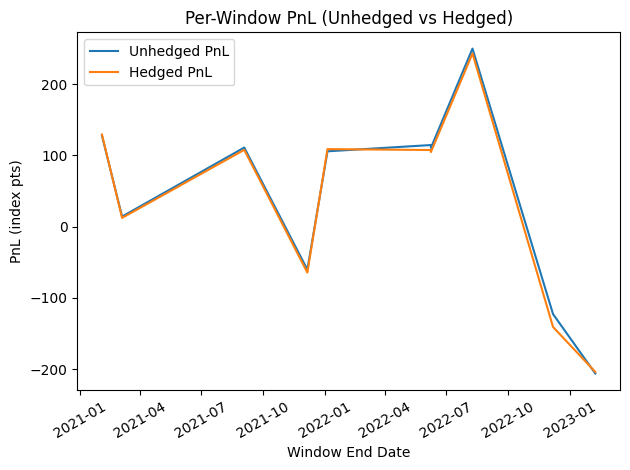

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sort by window end-date so the x-axis is chronological
res = results_df.sort_values('end').reset_index(drop=True).copy()

plt.figure()
plt.plot(res['end'], res['pnl_unhedged'], label='Unhedged PnL')
plt.plot(res['end'], res['pnl_hedged'], label='Hedged PnL')
plt.title('Per-Window PnL (Unhedged vs Hedged)')
plt.xlabel('Window End Date')
plt.ylabel('PnL (index pts)')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


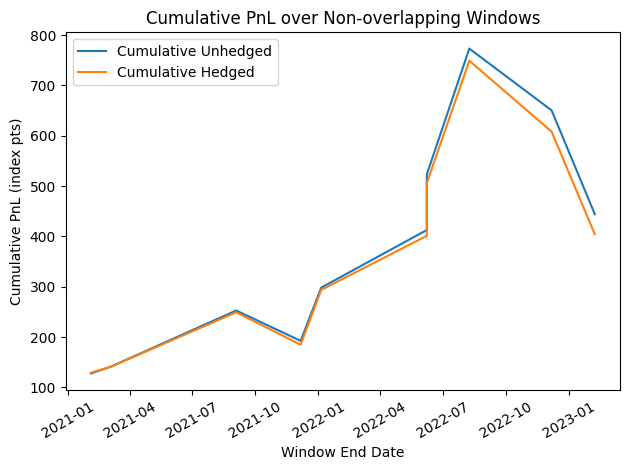

In [25]:
res = results_df.sort_values('end').reset_index(drop=True).copy()

res['cum_unhedged'] = res['pnl_unhedged'].cumsum()
res['cum_hedged']   = res['pnl_hedged'].cumsum()

plt.figure()
plt.plot(res['end'], res['cum_unhedged'], label='Cumulative Unhedged')
plt.plot(res['end'], res['cum_hedged'], label='Cumulative Hedged')
plt.title('Cumulative PnL over Non-overlapping Windows')
plt.xlabel('Window End Date')
plt.ylabel('Cumulative PnL (index pts)')
plt.legend()
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


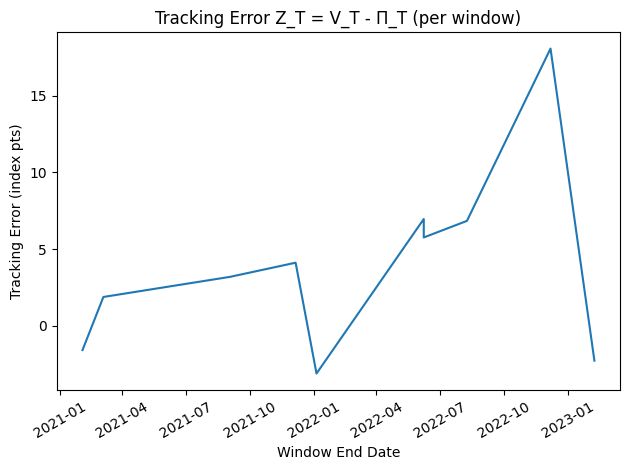

In [26]:
res = results_df.sort_values('end').reset_index(drop=True).copy()

plt.figure()
plt.plot(res['end'], res['tracking_error'])
plt.title('Tracking Error Z_T = V_T - Π_T (per window)')
plt.xlabel('Window End Date')
plt.ylabel('Tracking Error (index pts)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

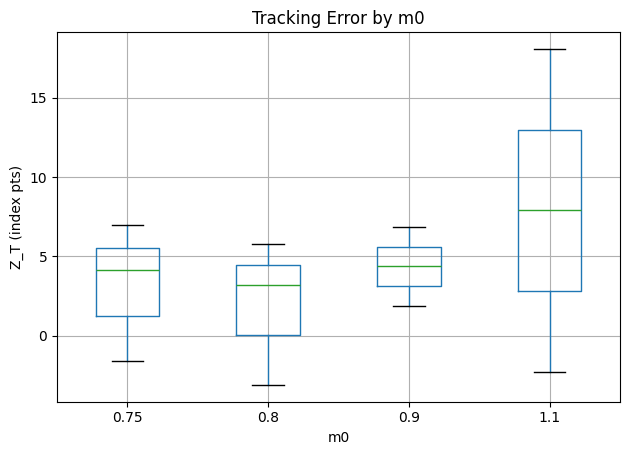

In [27]:
# Boxplot of tracking error by m0
plt.figure()
results_df.boxplot(column='tracking_error', by='m0')
plt.title('Tracking Error by m0')
plt.suptitle('')
plt.xlabel('m0')
plt.ylabel('Z_T (index pts)')
plt.tight_layout()
plt.show()


In [28]:
# Compute statistics per m0
perf = results_df.groupby('m0').agg(
    windows       = ('tracking_error', 'count'),
    te_mean       = ('tracking_error', 'mean'),
    te_median     = ('tracking_error', 'median'),
    te_std        = ('tracking_error', 'std'),
    hedged_mean   = ('pnl_hedged', 'mean'),
    hedged_std    = ('pnl_hedged', 'std'),
    unhedged_mean = ('pnl_unhedged', 'mean'),
    unhedged_std  = ('pnl_unhedged', 'std')
).reset_index()

# "Monthly" windows; annualize Sharpe by sqrt(12)
perf['hedged_sharpe_ann']   = perf['hedged_mean']   / perf['hedged_std']   * np.sqrt(12)
perf['unhedged_sharpe_ann'] = perf['unhedged_mean'] / perf['unhedged_std'] * np.sqrt(12)

# Hit rate: how often hedging reduces |Z_T| vs 0 (optional)
# (By design, smaller |Z_T| is better; you can also compare |pnl_hedged - pnl_unhedged| reductions if desired.)
# Here we just keep core stats.
perf = perf.fillna(0.0)
perf


,m0,windows,te_mean,te_median,te_std,hedged_mean,hedged_std,unhedged_mean,unhedged_std,hedged_sharpe_ann,unhedged_sharpe_ann
0,0.75,3,3.171945,4.119824,4.346264,57.461388,106.110258,60.633333,104.939093,1.875899,2.001542
1,0.80,3,1.954720,3.199271,4.560436,107.086946,2.165036,109.041667,2.885452,171.341313,130.908922
2,0.90,2,4.365430,4.365430,3.503397,127.672070,163.143994,132.037500,166.647391,2.710912,2.744665
3,1.10,2,7.900874,7.900874,14.373040,-172.325874,44.599666,-164.425000,58.972706,-13.384727,-9.658450


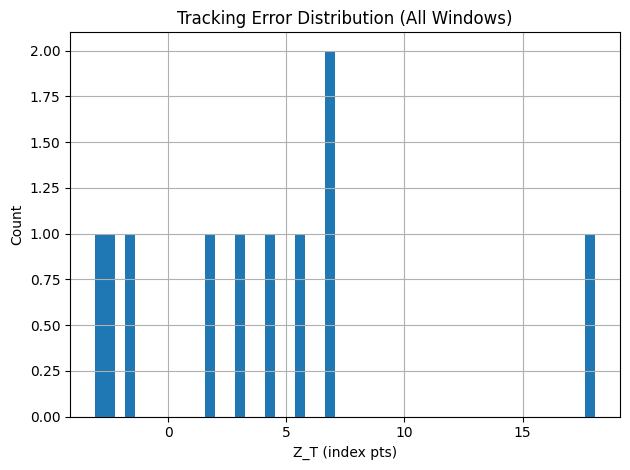

In [29]:
plt.figure()
results_df['tracking_error'].hist(bins=50)
plt.title('Tracking Error Distribution (All Windows)')
plt.xlabel('Z_T (index pts)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


In [33]:
import numpy as np
import pandas as pd

# --- Choose WHICH window to inspect ---
# Option 1: by row index in results_df (change idx as you like)
idx = 0  # e.g., inspect the first successful window
row = results_df.iloc[idx]

# Option 2 (alternative): pick by m0 and earliest end date
# m0_pick = 0.9
# row = results_df[results_df['m0'] == m0_pick].sort_values('end').iloc[0]

print("Inspecting window:", dict(start=row['start'], end=row['end'], m0=row['m0']))

# --- Map its start date to a start_idx in the backtest calendar used for df_1m_bt ---
dates_bt = np.sort(df_1m_bt['date'].unique())
try:
    start_idx = int(np.where(dates_bt == pd.Timestamp(row['start']))[0][0])
except Exception:
    raise RuntimeError(f"Could not map start date {row['start']} to an index in df_1m_bt. "
                       "Check that df_1m_bt covers this date.")

# --- Re-run that single window to get the per-day timeline ---
out_window = run_single_window(df_1m_bt, start_idx=start_idx, m0=float(row['m0']))
if out_window is None:
    raise RuntimeError("Re-run of the selected window failed (see printed logs above). Choose another window.")

timeline = out_window['timeline'].sort_values('date').reset_index(drop=True)
display(timeline.head(10))


Inspecting window: {'start': Timestamp('2021-01-04 00:00:00'), 'end': Timestamp('2021-02-03 00:00:00'), 'm0': np.float64(0.75)}
[get_window_dates] start=2021-01-04 end=2021-02-03 len=22 (includes final valuation day).
[choose_strike_for_m0] spot0=3705.0000, m0=0.750, target=2778.7500 -> K=2800.0
[nearest_atm_strike] spot0=3705.0000 -> K_ATM=3705.0

[day 1/21] 2021-01-04 -> 2021-01-05
[pick_one] cp=C, K=2800.0, dte=21, mid=902.4000, delta=0.9869, vega=29.5673, spread=6.2000, OI=0, vol=0
[pick_one] cp=P, K=2800.0, dte=21, mid=2.2500, delta=-0.0130, vega=29.6517, spread=0.2000, OI=122, vol=3
[pick_one] cp=C, K=3705.0, dte=21, mid=68.4500, delta=0.4987, vega=354.0529, spread=0.7000, OI=7, vol=1
[ratios @ 2021-01-04] V=904.6500 ΔV=0.973918 κV=59.218980 | ΔH=0.498739 κH=354.052900 -> φ1=0.167260, φ0=0.890499
[next fetch] cp=C, K=2800.0, dte=22, mid=927.0500
[next fetch] cp=P, K=2800.0, dte=22, mid=2.0000
[next fetch] cp=C, K=3705.0, dte=22, mid=82.9500
[half_spread] C K=3705.0 -> half-spread

,date,spot,K_straddle,K_hedge,V_t,dV_t,kV_t,H_cp,H_mid,dH_t,kH_t,phi_opt,phi_under,cost_opt,cost_under,pnl_opt,pnl_under,pnl_unhedged,Pi_t,Pi_t1
0,2021-01-04,3705.0,2800.0,3705.0,904.650,0.973918,59.21898,C,68.45,0.498739,354.0529,0.167260,0.890499,0.058541,0.0,2.425274,22.262470,24.400,904.650000,929.279202
1,2021-01-05,3730.0,2800.0,3705.0,929.050,0.977194,53.63477,C,82.95,0.553945,361.4652,0.148382,0.894999,0.004720,0.0,2.470553,22.374969,24.850,929.279202,954.120005
2,2021-01-06,3755.0,2800.0,3705.0,953.900,0.970661,66.66732,C,99.60,0.599847,347.3597,0.191926,0.855535,0.026127,0.0,6.890139,42.776741,53.300,954.120005,1003.760759
3,2021-01-07,3805.0,2800.0,3705.0,1007.200,0.982062,45.21572,C,135.50,0.707532,320.9311,0.140889,0.882378,0.035726,0.0,2.056982,22.059460,19.875,1003.760759,1027.841476
4,2021-01-08,3830.0,2800.0,3705.0,1027.075,0.986958,33.53126,C,150.10,0.745233,294.4450,0.113880,0.902091,0.008103,0.0,-1.827767,-27.062736,-26.825,1027.841476,998.942870
5,2021-01-11,3800.0,2800.0,3705.0,1000.250,0.982971,40.72799,C,134.05,0.687970,322.0426,0.126468,0.895965,0.004406,0.0,0.644985,4.479825,7.525,998.942870,1004.063274
6,2021-01-12,3805.0,2800.0,3705.0,1007.775,0.970835,67.51721,C,139.15,0.690149,329.1651,0.205117,0.829274,0.027527,0.0,0.164093,4.146370,5.600,1004.063274,1008.346211
7,2021-01-13,3810.0,2800.0,3705.0,1013.375,0.981762,44.58763,C,139.95,0.717659,308.8590,0.144362,0.878159,0.015189,0.0,-0.757903,-8.781590,-14.500,1008.346211,998.791529
8,2021-01-14,3800.0,2800.0,3705.0,998.875,0.982108,45.06085,C,134.70,0.681674,332.5009,0.135521,0.889727,0.016799,0.0,-3.191519,-22.243172,-29.300,998.791529,973.340040
9,2021-01-15,3775.0,2800.0,3705.0,969.575,0.984437,37.73142,C,111.15,0.637126,338.8777,0.111342,0.913498,0.008463,0.0,2.443963,22.837448,29.675,973.340040,998.612989


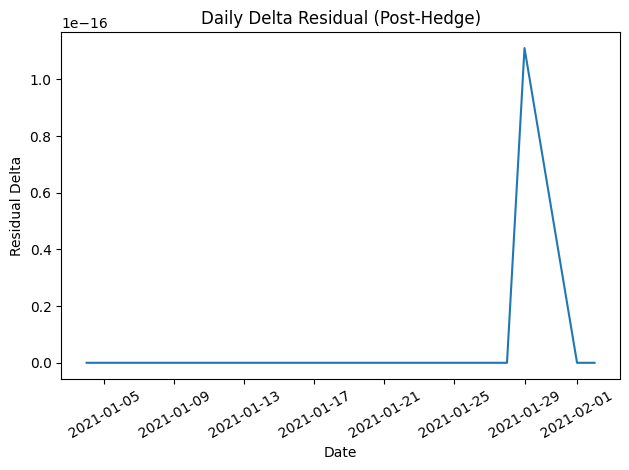

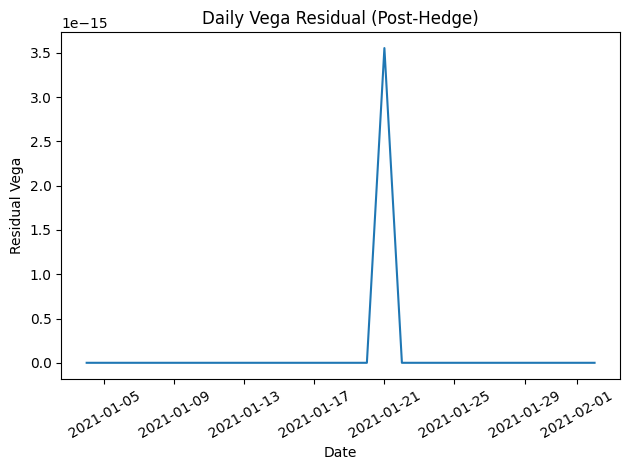

In [34]:
# Requires: timeline = out_window['timeline']
tl = timeline.copy()

# Residuals after hedge (what's left unhedged)
tl['delta_residual'] = tl['dV_t'] - (tl['phi_opt']*tl['dH_t'] + tl['phi_under'])
tl['vega_residual']  = tl['kV_t'] - (tl['phi_opt']*tl['kH_t'])

# 7a) Delta residual over days
plt.figure()
plt.plot(tl['date'], tl['delta_residual'])
plt.title('Daily Delta Residual (Post-Hedge)')
plt.xlabel('Date')
plt.ylabel('Residual Delta')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 7b) Vega residual over days
plt.figure()
plt.plot(tl['date'], tl['vega_residual'])
plt.title('Daily Vega Residual (Post-Hedge)')
plt.xlabel('Date')
plt.ylabel('Residual Vega')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


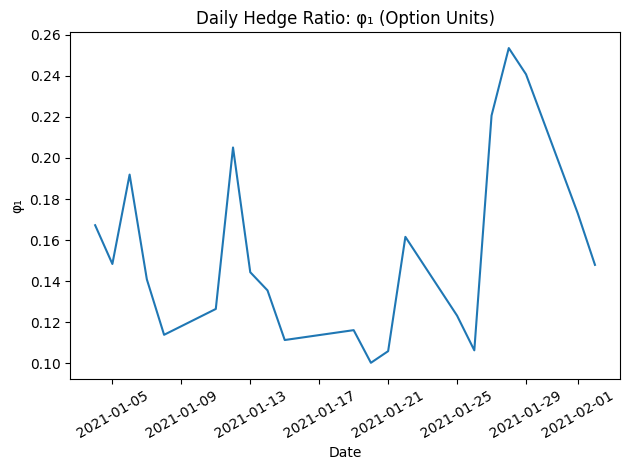

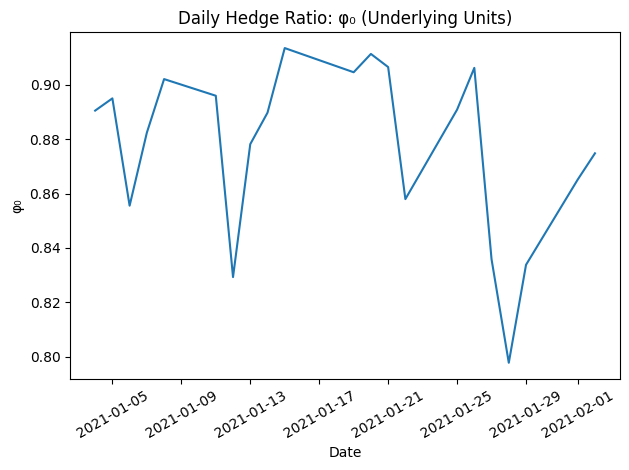

In [35]:
tl = timeline.copy()

plt.figure()
plt.plot(tl['date'], tl['phi_opt'])
plt.title('Daily Hedge Ratio: φ₁ (Option Units)')
plt.xlabel('Date')
plt.ylabel('φ₁')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tl['date'], tl['phi_under'])
plt.title('Daily Hedge Ratio: φ₀ (Underlying Units)')
plt.xlabel('Date')
plt.ylabel('φ₀')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


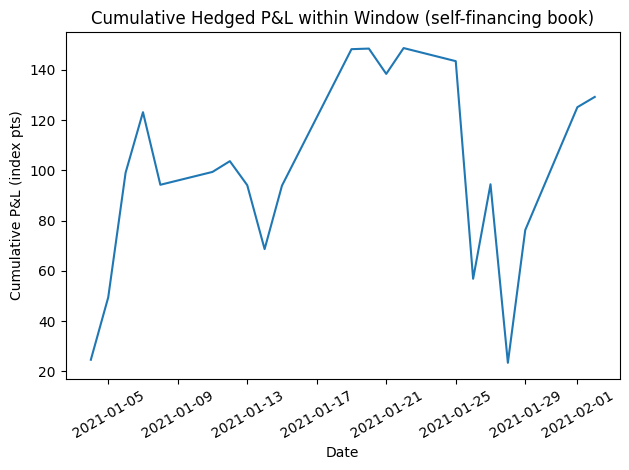

In [36]:
tl = timeline.copy()
tl = tl.sort_values('date').reset_index(drop=True)

# Per-day hedge P&L net of costs
tl['pnl_net'] = tl['pnl_opt'] + tl['pnl_under'] - tl['cost_opt'] - tl['cost_under']
tl['cum_pnl_net'] = tl['pnl_net'].cumsum()

plt.figure()
plt.plot(tl['date'], tl['cum_pnl_net'])
plt.title('Cumulative Hedged P&L within Window (self-financing book)')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (index pts)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
